# Project 02 - Image Processing

## Student Information

- Full name: Hồ Phước Hoàn
- Student ID: 22127119
- Class: 22CLC05

## Required Libraries

In [4]:
# IMPORT YOUR LIBS HERE
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Function Definitions

In [5]:
def read_img(img_path: str) -> Image.Image:
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
    Image.Image
        Image
    '''

    # YOUR CODE HERE
    return Image.open(img_path)


def show_img(img: np.ndarray, title: str) -> None:
    '''
    Show image

    Parameters
    ----------
    img : np.ndarray
        Image array
    title : str
        Image title
    '''

    # YOUR CODE HERE
    plt.imshow(img) # choose img to show
    plt.title(title)
    plt.show() # show image


def save_img(img: np.ndarray, img_path: str) -> None:
    '''
    Save image to img_path

    Parameters
    ----------
    img : np.ndarray
        Image array
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    Image.fromarray(img).save(img_path)


#--------------------------------------------------------------------------------
# YOUR FUNCTIONS HERE
# 1. Thay đổi độ sáng cho ảnh
def adjustBrightness(img: np.ndarray, alpha: float=50.0) -> np.ndarray:
    '''
    Adjust brightness of image

    Parameters
    ----------
    img : np.ndarray
        Image array
    alpha : float, optional
        The degree of brightness to adjust. Default is 50.0.

    Returns
    -------
    np.ndarray
        Image
    '''

    # convert to float32 in order to prevent overflow
    img = img.astype(np.float32)
    # np.clip: to limit the values in an array
    img = np.clip(img + alpha, 0, 255)
    return img.astype(np.uint8)
    

# 2. Thay đổi độ tương phản
def adjustContrast(img: np.ndarray, alpha: float=2.0) -> np.ndarray:
    '''
    Adjust contrast of image

    Parameters
    ----------
    img : np.ndarray
        Image array
    alpha : float, optional
        The degree of contrast to adjust. Default is 2.0.

    Returns
    -------
    np.ndarray
        Image
    '''

    img = img.astype(np.float32)
    img = np.clip(img * alpha, 0, 255)
    return img.astype(np.uint8)


# 3. Lật ảnh ngang - dọc
def flipImage(img: np.ndarray, axis: bool=0) -> np.ndarray:
    '''
    Flip image vertically or horizontally

    Parameters
    ----------
    img : np.ndarray
        Image array
    axis : bool, optional
        symmetrical axis
        0 : vertically (up/down). Default
        1 : horizontally (left/right)
        
    Returns
    -------
    np.ndarray
        Image
    '''

    return np.flip(img, axis)


# 4. Chuyển đổi ảnh RGB thành ảnh xám/sepia
# 4.1. Gray
def rgb_gray(img: np.ndarray) -> np.ndarray:
    '''
    Convert rgb image to gray image using Luminosity Method

    Parameters
    ----------
    img : np.ndarray
        Image array
        
    Returns
    -------
    np.ndarray
        Image
    '''

    img = img.astype(np.float32)
    # dot product N-D array and 1-D array and convert shape from (n, m) to (n, m, 1)
    img = np.dot(img, [0.299, 0.587, 0.114])[..., np.newaxis]
    # convert shape from (n, m, 1) to be 2D image (n, m, 3)
    return img.repeat(3, axis=2).astype(np.uint8)


# 4.2. Sepia
def rgb_sepia(img: np.ndarray) -> np.ndarray:
    '''
    Convert rgb image to sepia image

    Parameters
    ----------
    img : np.ndarray
        Image array
        
    Returns
    -------
    np.ndarray
        Image
    '''

    img = img.astype(np.float32)
    # reshape image from (n, m, 3) -> (n*m, 3)
    img_1d = img.reshape(-1, 3)
    sepia_arr = np.array([
        [0.393, 0.769, 0.189],
        [0.349, 0.686, 0.168],
        [0.272, 0.534, 0.131]
    ])
    # matmul 2 matrix: (n*m,3),(3,3) -> (n*m, 3)
    img_1d = img_1d @ sepia_arr.T
    img_1d = np.clip(img_1d, 0, 255).astype(np.uint8)
    return img_1d.reshape(img.shape)
    

# 5. Làm mờ/sắc nét ảnh
# 5.1. Làm mờ
def gaussian_kernel(size: int=5, sigma: float=1.0) -> np.ndarray:
    '''
    Generate a 1D Gaussian kernel.

    This function creates a 1D Gaussian kernel with the specified size and standard deviation (sigma).

    Parameters
    ----------
    size : int
        The size of the kernel. Should be an odd number. Default is 5.
    sigma : float, optional
        The standard deviation of the Gaussian distribution. Default is 1.0.

    Returns
    -------
    np.ndarray
        A 1D numpy array representing the Gaussian kernel.
    '''

    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    return np.exp(-0.5 * (ax / sigma)**2) / (sigma * np.sqrt(2 * np.pi))


def convolve(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    '''
    Perform 1D convolution on a 2D image array using a given kernel.

    This function first convolves each row of the image with the kernel,
    and then convolves each column of the intermediate result with the same kernel.

    Parameters:
    ----------
    img : np.ndarray
        Image array
    kernel : np.ndarray 
        The 1D convolution kernel.

    Returns:
    -------
    np.ndarray
        The convolved image with the same shape as the input image.
    '''

    # Convolve each row
    temp_result = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[2]):
            temp_result[i, :, j] = np.convolve(img[i, :, j], kernel, mode='same')
    
    # Convolve each column
    result = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            result[:, i, j] = np.convolve(temp_result[:, i, j], kernel, mode='same')
    
    return result.clip(0, 255).astype(np.uint8)


# 5.2. Làm sắc nét ảnh
def unsharp_mask(img: np.ndarray, size: int=5, sigma: float=1.0, strength: float=1.5) -> np.ndarray:
    '''
    Sharpen image using unsharp masking formula

    Parameters:
    ----------
    img : np.ndarray
        Image array
    size : int
        The size of the kernel. Should be an odd number. Default is 5.
    sigma : float, optional
        The standard deviation of the Gaussian distribution. Default is 1.0.
    strength : float, optional
        The strength of the sharpening effect. Default is 1.5
        
    Returns:
    -------
    np.ndarray 
        The sharpened image
    '''

    # cast type to float32 to prevent overflow
    img = img.astype(np.float32)
    
    # Create Gaussian kernel
    kernel = gaussian_kernel(size, sigma)
    
    # Apply Gaussian blur
    blurred_img = convolve(img, kernel)
    
    # Apply the formula: sharpened = original + (original − blurred) × amount
    sharpened_img = img + (img - blurred_img) * strength
    
    return sharpened_img.clip(0, 255).astype(np.uint8)


# 6. Cắt ảnh theo kích thước (cắt ở trung tâm)
def crop_img_center(img: np.ndarray, height: float=256.0, width: float=256.0) -> np.ndarray:
    '''
    Crop the image to size (crop from the center)

    Parameters
    ----------
    img : np.ndarray
        Image array
    height: float, optional
        Cropped image's height. Default is 256.0.
    width: float, optional
        Cropped image's width. Default is 256.0.
         
    Returns
    -------
    np.ndarray
        Image
    '''

    # height or width must over 0 and Less than or equal to original image
    if 0 < height <= img.shape[0] and 0 < width <= img.shape[1]:
        top = np.uint16((img.shape[0] - height) / 2)
        bottom = np.uint16((img.shape[0] + height) / 2)
        left = np.uint16((img.shape[1] - width) / 2)
        right = np.uint16((img.shape[1] + width) / 2)

        return img[top:bottom, left:right]

    return None

# 7. Cắt ảnh theo khung
# 7.1. Khung tròn
def crop_img_circular_frame(img: np.ndarray) -> np.ndarray:
    '''
    Crop the image to circular frame

    Parameters
    ----------
    img : np.ndarray
        Image array
         
    Returns
    -------
    np.ndarray
        Image
    '''

    # Get the dimensions of the image
    height, width, channels = img.shape

    # create y axis, x axis
    ay, ax = np.ogrid[:height, :width]
    center_y, center_x = height // 2, width // 2
    radius = min(center_y, center_x)
    # create 2d boolean array, true: pixels inside circle, false: others.
    mask = (ax - center_x)**2 + (ay - center_y)**2 <= radius**2
    crop_img = np.zeros_like(img)
    for c in range(channels):
        crop_img[:, :, c] = img[:, :, c] * mask
        
    return crop_img


# 7.2. Khung là 2 hình elip chéo nhau
def crop_img_2_crossed_ellipses_frame(img: np.ndarray, angle: float=np.pi/3) -> np.ndarray:
    '''
    Crop the image to 2 crossed eclipse frame

    Parameters
    ----------
    img : np.ndarray
        Image array
    angle : float, optional
        Angle of the eclipse. Default is np.pi/3.
            
    Returns
    -------
    np.ndarray
        Image
    '''

    # Get the dimensions of the image
    height, width, channels = img.shape

    # create y axis, x axis
    ay, ax = np.ogrid[:height, :width]
    center_y, center_x = height // 2, width // 2
    # create 2d boolean array, true: pixels inside eclipse, false: others.
    eclipse_center_y, eclipse_center_x = ay - center_y, ax - center_x
    mask = (eclipse_center_x / center_x)**2 + (eclipse_center_y / center_y)**2 - \
            2*eclipse_center_x*eclipse_center_y*np.cos(angle) / (center_x*center_y) <= np.sin(angle)**2
    # To have 2 crossed eclipses
    mask += np.fliplr(mask)
    crop_img = np.zeros_like(img)
    for c in range(channels):
        crop_img[:, :, c] = img[:, :, c] * mask
        
    return crop_img


# 8. Thu nhỏ, phóng to ảnh (zoom out/zoom in)
def bicubic_kernel(x: np.ndarray):
    '''
    Compute the bicubic kernel function.

    This function calculates the value of the bicubic kernel for a given input x and is used in bicubic interpolation.

    Parameters
    ----------
    x : np.ndarray
        Input values for which to compute the kernel.
            
    Returns
    -------
    np.ndarray
        Computed values of the bicubic kernel.
    '''

    a = -0.5
    abs_x = np.abs(x)
    return np.where(abs_x <= 1, (a + 2) * abs_x**3 - (a + 3) * abs_x**2 + 1,
                    np.where(abs_x < 2, a * abs_x**3 - 5 * a * abs_x**2 + 8 * a * abs_x - 4 * a,
                             0))


def bicubic_interpolation(img: np.ndarray, zoom_factor: float=2.0):
    '''
    Perform bicubic interpolation on an image.

    This function resizes an image using bicubic interpolation. It considers
    a 4x4 neighborhood of pixels to compute each new pixel value, resulting
    in smoother transitions compared to simpler interpolation methods.

    Parameters
    ----------
    img : np.ndarray
        Image array
    zoom_factor : float, optional
        Factor by which to zoom the image. Default is 2.0.
            
    Returns
    -------
    np.ndarray
        zoomed image array with shape (int(height * zoom_factor), int(width * zoom_factor), channels),
    '''

    old_h, old_w, channels = img.shape
    new_h, new_w = int(old_h * zoom_factor), int(old_w * zoom_factor)
    output = np.zeros((new_h, new_w, channels))

    ay, ax = np.ogrid[0:new_h, 0:new_w]
    ay, ax = ay.astype(np.float32) / zoom_factor, ax.astype(np.float32) / zoom_factor
    
    x0, y0 = np.floor(ax).astype(np.int32).clip(0, old_w - 1), np.floor(ay).astype(np.int32).clip(0, old_h - 1)
    
    dx, dy = ax - x0, ay - y0

    # Pre-compute weights
    weights = np.zeros((4, 4, new_h, new_w))
    for m in range(-1, 3):
        for n in range(-1, 3):
            weights[m, n] = bicubic_kernel(dx - n) * bicubic_kernel(dy - m)

    # Perform interpolation
    for c in range(channels):
        for m in range(-1, 3):
            for n in range(-1, 3):
                y, x = np.clip(y0 + m, 0, old_h - 1), np.clip(x0 + n, 0, old_w - 1)
                output[..., c] += img[y, x, c] * weights[m, n]

    return np.clip(output, 0, 255).astype(np.uint8)


def modify_file_path(original_path: str, new_suffix: str, save_path: str):
    '''
    Modifies file name by adding new suffix for output file

    Parameters
    ----------
    original_path : str
        path to input file (have file name and extension)
    new_suffix : str
        new_suffix for file name. eg: _blur, _sharp, ...
    save_path : str
        path to output file (just path to folder)
            
    Returns
    -------
    str
        output path
    '''
    
    last_slash_idx = original_path.rfind('/')
    last_dot_idx = original_path.rfind('.')
    return save_path + original_path[last_slash_idx:last_dot_idx] + new_suffix + original_path[last_dot_idx:]

<ins>Note:</ins> For clarity, include docstrings with each function.

## Your tests

In [6]:
# YOUR CODE HERE
# import time
# # Load the image
# img = read_img("/mnt/c/Users/phuoc/Work Space/My Uni/Applied Mathematics and Statistics/Lab/Project 2 - lab03/Lenna_(test_image).png")

# # Measure the time taken to apply the interpolation
# start_time = time.time()

# zoom_factor = 2.0
# zoomed_img = bicubic_interpolation(img, zoom_factor)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Time taken to apply interpolation: {elapsed_time:.4f} seconds")

# # Set up the figure
# fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# # Display original image
# axes[0].imshow(img)
# axes[0].axis('off')
# axes[0].set_title("Original")

# # Display interpolated image
# axes[1].imshow(zoomed_img)
# axes[1].axis('off')
# axes[1].set_title("Interpolated")

# # Display image plot 3
# # axes[2].imshow(rgb_sepia(img))
# # axes[2].axis('off')
# # axes[2].set_title("Decrease")

# plt.tight_layout()
# plt.show()

## Main FUNCTION

In [7]:
# YOUR CODE HERE
def main() -> None:
    img_path = input("Enter file path or file name of image, must have extension of image file: ") # image path to input
    out_img_path = input("Enter path to save: ") # image path to save

    original_img = np.array(read_img(img_path))
    img_after:np.ndarray = None

    while True:

        print("Image Processing Menu:")
        print("0. Execute all function")
        print("1. Adjust brightness")
        print("2. Adjust contrast")
        print("3. Flip (vertically / horizontally)")
        print("4. Rgb - (gray / sepia)")
        print("5. Blur / sharpen")
        print("6. Crop to size (from the center)")
        print("7. Crop to (circular / 2 crossed eclipses) frame")
        print("8. Zoom in / zoom out")
        print("9. Exit")

        choice = int(input("Enter your choice: "))

        if choice == 0:
            img_after = adjustBrightness(original_img, alpha=50.0)
            show_img(img_after, title="Adjust Image Brightness")
            save_img(img_after, modify_file_path(img_path, '_brightness', out_img_path))

            img_after = adjustContrast(original_img, alpha=2.0)
            show_img(img_after, title="Adjust Image Contrast")
            save_img(img_after, modify_file_path(img_path, '_contrast', out_img_path))

            img_after = flipImage(original_img, axis=0)
            show_img(img_after, title="Flip Image Vertically")
            save_img(img_after, modify_file_path(img_path, '_flip_vertically', out_img_path))
            
            img_after = flipImage(original_img, axis=1)
            show_img(img_after, title="Flip Image Horizontally")
            save_img(img_after, modify_file_path(img_path, '_flip_horizontally', out_img_path))

            img_after = rgb_gray(original_img)
            show_img(img_after, title="Gray Image")
            save_img(img_after, modify_file_path(img_path, '_gray', out_img_path))

            img_after = rgb_sepia(original_img)
            show_img(img_after, title="Sepia Image")
            save_img(img_after, modify_file_path(img_path, '_sepia', out_img_path))

            img_after = convolve(original_img, kernel=gaussian_kernel(size=5, sigma=1.0))
            show_img(img_after, title="Blurred Image")
            save_img(img_after, modify_file_path(img_path, '_blur', out_img_path))

            img_after = unsharp_mask(original_img, size=5, sigma=1.0, strength=1.5)
            show_img(img_after, title="Sharpened Image")
            save_img(img_after, modify_file_path(img_path, '_sharp', out_img_path))

            img_after = crop_img_center(original_img, height=256, width=256)
            if img_after is None:
                print("The size is invalid, please set valid size!")
                break
            show_img(img_after, title="Crop Image to Center Frame")
            save_img(img_after, modify_file_path(img_path, '_crop_center', out_img_path))

            img_after = crop_img_circular_frame(original_img)
            show_img(img_after, title="Crop Image to Circular Frame")
            save_img(img_after, modify_file_path(img_path, '_crop_circular', out_img_path))

            img_after = crop_img_2_crossed_ellipses_frame(original_img)
            show_img(img_after, title="Crop Image to 2 Crossed Eclipses Frame")
            save_img(img_after, modify_file_path(img_path, '_crop_eclipses', out_img_path))

            img_after = bicubic_interpolation(original_img, zoom_factor=2.0)
            show_img(img_after, title="Zoomed in Image")
            save_img(img_after, modify_file_path(img_path, '_zoom_in', out_img_path))

            img_after = bicubic_interpolation(original_img, zoom_factor=1/2)
            show_img(img_after, title="Zoomed out Image")
            save_img(img_after, modify_file_path(img_path, '_zoom_out', out_img_path))

        elif choice == 1:
            img_after = adjustBrightness(original_img, alpha=50.0)
            show_img(img_after, title="Adjust Image Brightness")
            save_img(img_after, modify_file_path(img_path, '_brightness', out_img_path))

        elif choice == 2:
            img_after = adjustContrast(original_img, alpha=2.0)
            show_img(img_after, title="Adjust Image Contrast")
            save_img(img_after, modify_file_path(img_path, '_contrast', out_img_path))

        elif choice == 3:
            print("0. Flip vertically")
            print("1. Flip horizontally")
            choice = int(input("Enter your choice: "))
            
            if choice == 0:
                img_after = flipImage(original_img, axis=0)
                show_img(img_after, title="Flip Image Vertically")
                save_img(img_after, modify_file_path(img_path, '_flip_vertically', out_img_path))
            
            elif choice == 1:
                img_after = flipImage(original_img, axis=1)
                show_img(img_after, title="Flip Image Horizontally")
                save_img(img_after, modify_file_path(img_path, '_flip_horizontally', out_img_path))
            
            else:
                print("Invalid choice")
        
        elif choice == 4:
            print("0. Rgb - gray")
            print("1. Rgb - sepia")
            choice = int(input("Enter your choice: "))
            
            if choice == 0:
                img_after = rgb_gray(original_img)
                show_img(img_after, title="Gray Image")
                save_img(img_after, modify_file_path(img_path, '_gray', out_img_path))
            
            elif choice == 1:
                img_after = rgb_sepia(original_img)
                show_img(img_after, title="Sepia Image")
                save_img(img_after, modify_file_path(img_path, '_sepia', out_img_path))
            
            else:
                print("Invalid choice")
       
        elif choice == 5:
            print("0. Blur")
            print("1. Sharpen")
            choice = int(input("Enter your choice: "))
            
            if choice == 0:
                img_after = convolve(original_img, kernel=gaussian_kernel(size=5, sigma=1.0))
                show_img(img_after, title="Blurred Image")
                save_img(img_after, modify_file_path(img_path, '_blur', out_img_path))
            
            elif choice == 1:
                img_after = unsharp_mask(original_img, size=5, sigma=1.0, strength=1.5)
                show_img(img_after, title="Sharpened Image")
                save_img(img_after, modify_file_path(img_path, '_sharp', out_img_path))
            
            else:
                print("Invalid choice")
        
        elif choice == 6:
            img_after = crop_img_center(original_img, height=256, width=256)
            if img_after is None:
                print("The size is invalid, please set valid size!")
                break
            show_img(img_after, title="Crop Image to Center Frame")
            save_img(img_after, modify_file_path(img_path, '_crop_center', out_img_path))
        
        elif choice == 7:
            print("0. Crop to circular frame")
            print("1. Crop to 2 crossed eclipses frame")
            choice = int(input("Enter your choice: "))
            
            if choice == 0:
                img_after = crop_img_circular_frame(original_img)
                show_img(img_after, title="Crop Image to Circular Frame")
                save_img(img_after, modify_file_path(img_path, '_crop_circular', out_img_path))
            
            elif choice == 1:
                img_after = crop_img_2_crossed_ellipses_frame(original_img)
                show_img(img_after, title="Crop Image to 2 Crossed Eclipses Frame")
                save_img(img_after, modify_file_path(img_path, '_crop_eclipses', out_img_path))
            
            else:
                print("Invalid choice")
        
        elif choice == 8:
            print("0. Zoom in")
            print("1. Zoom out")
            choice = int(input("Enter your choice: "))
            
            if choice == 0:
                img_after = bicubic_interpolation(original_img, zoom_factor=2.0)
                show_img(img_after, title="Zoomed in Image")
                save_img(img_after, modify_file_path(img_path, '_zoom_in', out_img_path))
            
            elif choice == 1:
                img_after = bicubic_interpolation(original_img, zoom_factor=1/2)
                show_img(img_after, title="Zoomed out Image")
                save_img(img_after, modify_file_path(img_path, '_zoom_out', out_img_path))
            
            else:
                print("Invalid choice")
        
        elif choice == 9:
            break
        
        else:
            print("Invalid choice")

Image Processing Menu:
0. Execute all function
1. Adjust brightness
2. Adjust contrast
3. Flip (vertically / horizontally)
4. Rgb - (gray / sepia)
5. Blur / sharpen
6. Crop to size (from the center)
7. Crop to (circular / 2 crossed eclipses) frame
8. Zoom in / zoom out
9. Exit


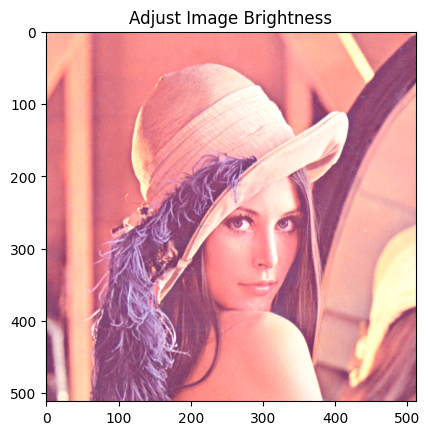

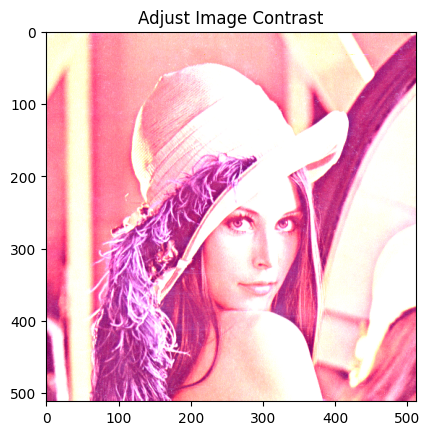

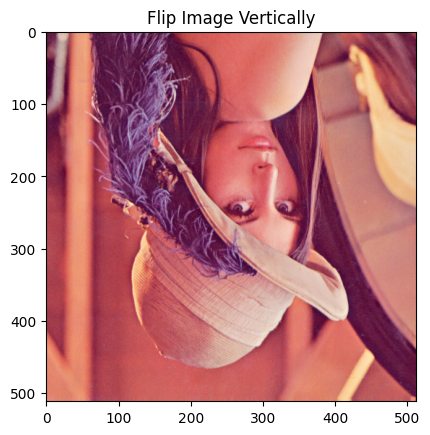

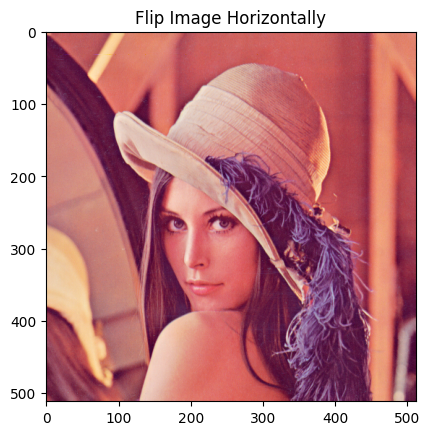

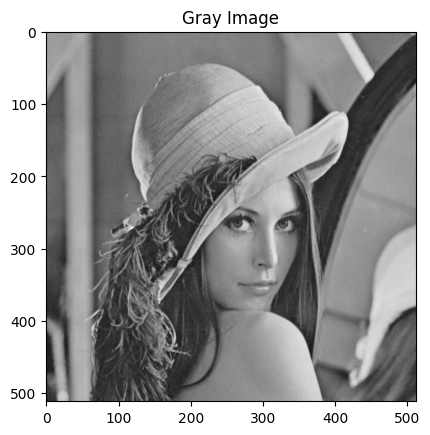

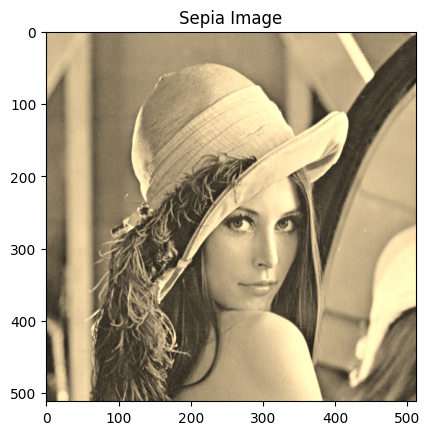

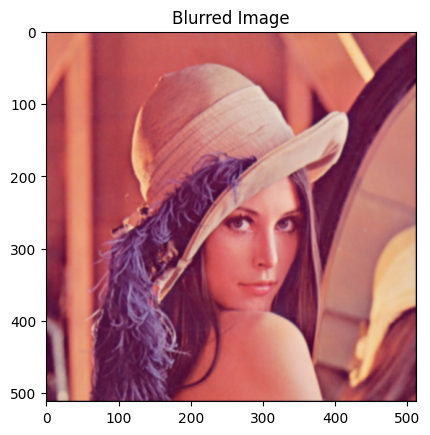

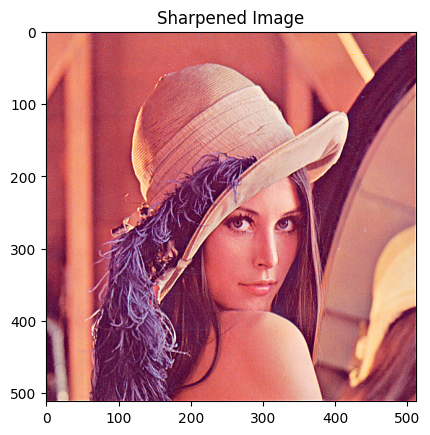

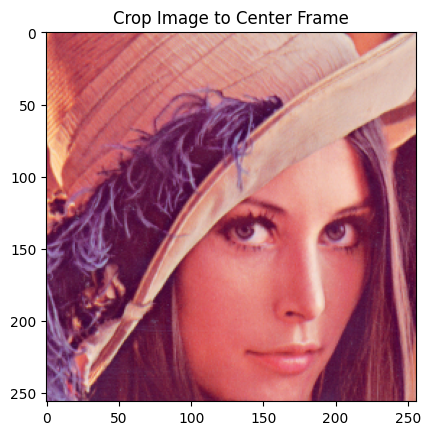

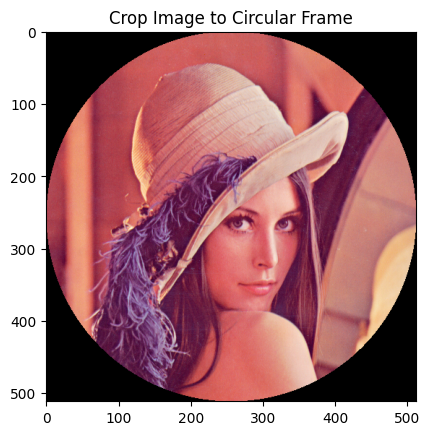

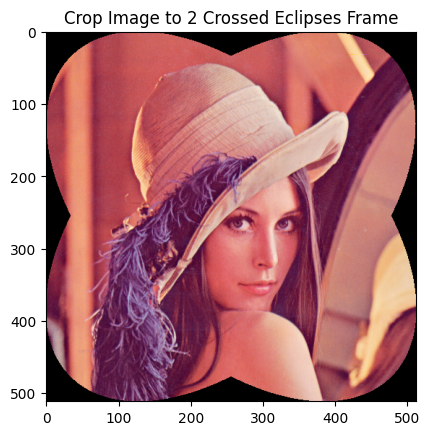

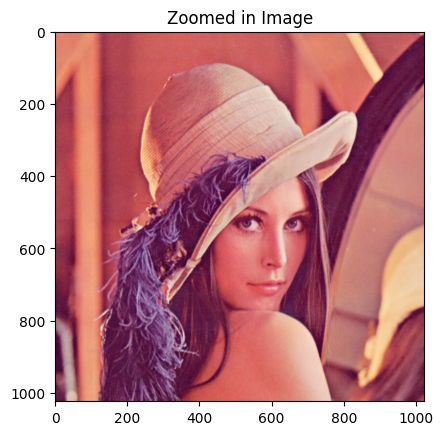

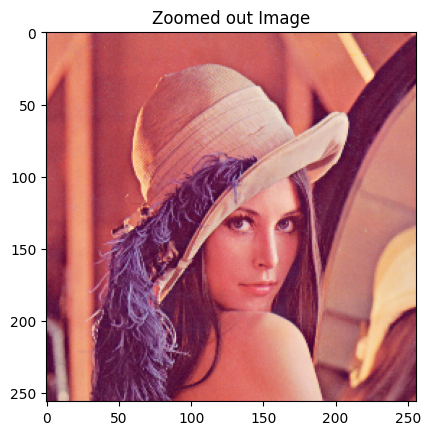

Image Processing Menu:
0. Execute all function
1. Adjust brightness
2. Adjust contrast
3. Flip (vertically / horizontally)
4. Rgb - (gray / sepia)
5. Blur / sharpen
6. Crop to size (from the center)
7. Crop to (circular / 2 crossed eclipses) frame
8. Zoom in / zoom out
9. Exit


In [8]:
# Call main function
if __name__ == "__main__":
    main()